In [ ]:
# Importing libraries

import torch
import torchvision
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from torchvision.transforms import functional as F


### Task 1: Multi Object Tracking with Faster RCNN

#### Faster RCNN
Faster RCNN (Region-based Convolutional Neural Network) is a two-stage object detection model that combines the concepts of Region Proposal Networks (RPN) and classification and regression networks to detect objects in an image. The input image is passed through convolutional layers to generate a feature map. This feature map encodes the spatial information (position) and semantic information (content). The RPN is responsible for generating region proposals—regions in the feature map where objects are likely to exist. Pre-defined anchor boxes of different sizes and aspect ratios are placed over each location in the feature map. Each anchor box is classified as either foreground (likely contains an object) or background (no object). For anchor boxes classified as foreground, a bounding box regression is performed to adjust the anchor box to better fit the object. The RPN outputs a set of proposals (region candidates), which are likely to contain objects. These proposals are represented as bounding boxes in the feature map. The proposals from the RPN are mapped back to the original feature map. A fully connected layer classifies the object in the proposal into one of the predefined classes (e.g., "human","ball") or as "background. A regression network refines the coordinates of the bounding box to better fit the object.

In [2]:
# Loading the model

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/CS-GY-6613-Artificial-Intelligence/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Kalman Filter Class for Object Tracking
class KalmanFilter:
    def __init__(self):
        self.state = np.zeros(4)
        self.P = np.eye(4) * 1000
        self.F = np.array([[1, 0, 1, 0],
                           [0, 1, 0, 1],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.R = np.eye(2) * 0.1
        self.Q = np.eye(4) * 0.01

    def predict(self):
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state[:2]

    def update(self, measurement):
        y = measurement - (self.H @ self.state)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P


In [ ]:
# Helper function to detect the objects
# Label 1 is for humans and 37 for sports balls according to the COCO labels

def detect_objects(frame, threshold=0.7):
    frame_tensor = F.to_tensor(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(frame_tensor)[0]

    boxes = []
    scores = []
    labels = []
    for i, score in enumerate(predictions['scores']):
        if score > threshold and predictions['labels'][i] in [1, 37]:
            boxes.append(predictions['boxes'][i].cpu().numpy())
            scores.append(score.cpu().numpy())
            labels.append(predictions['labels'][i].cpu().numpy())

    return boxes, scores, labels


In [ ]:
# Initializing and Updating Tracks

tracks = []
track_id = 0

def create_new_track(detection):
    global track_id
    kf = KalmanFilter()
    kf.state[:2] = detection
    tracks.append({"id": track_id, "kf": kf, "missed": 0})
    track_id += 1

def update_tracks(detections):
    # Predict next positions for existing tracks
    predicted_positions = np.array([track["kf"].predict() for track in tracks])

    # Assign detections to predictions
    if len(detections) > 0 and len(predicted_positions) > 0:
        distances = np.linalg.norm(predicted_positions[:, None] - detections, axis=2)
        row_ind, col_ind = linear_sum_assignment(distances)

        # Update matched tracks
        for r, c in zip(row_ind, col_ind):
            if distances[r, c] < 50:
                tracks[r]["kf"].update(detections[c])
                tracks[r]["missed"] = 0
            else:
                tracks[r]["missed"] += 1

        # Unmatched detections and unmatched tracks
        unmatched_detections = set(range(len(detections))) - set(col_ind)
        unmatched_tracks = set(range(len(tracks))) - set(row_ind)

        # Create new tracks for unmatched detections
        for idx in unmatched_detections:
            create_new_track(detections[idx])

        # Remove stale tracks
        for idx in sorted(unmatched_tracks, reverse=True):
            if tracks[idx]["missed"] > 10:
                tracks.pop(idx)
    else:
        # Create new tracks if there are no existing predictions
        for detection in detections:
            create_new_track(detection)


In [ ]:
# Load video and process frame-by-frame

video_path = 'Football_match.mp4'
cap = cv2.VideoCapture(video_path)

output_frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    boxes, _, labels = detect_objects(frame)

    detections = np.array([[(box[0]+box[2])/2, (box[1]+box[3])/2] for box in boxes])
    update_tracks(detections)

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Draw tracking results
    for track in tracks:
        pos = track["kf"].state[:2]
        cv2.circle(frame, (int(pos[0]), int(pos[1])), 5, (0, 0, 255), -1)
        cv2.putText(frame, f'ID: {track["id"]}', (int(pos[0]), int(pos[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    output_frames.append(frame)

cap.release()


In [7]:
first_frame = output_frames[0]
frame_height, frame_width = first_frame.shape[:2]
print(frame_height, frame_width)

720 1280


In [8]:
# 7. Save or Display the Results
# Save processed frames as video or display as needed
output_video_path = 'Task1_Output.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame_width, frame_height))

for frame in output_frames:
    out.write(frame)

out.release()
print("Tracking completed and saved as Task1_Output.mp4")


Tracking completed and saved as Task1_Output.mp4


### Task 2

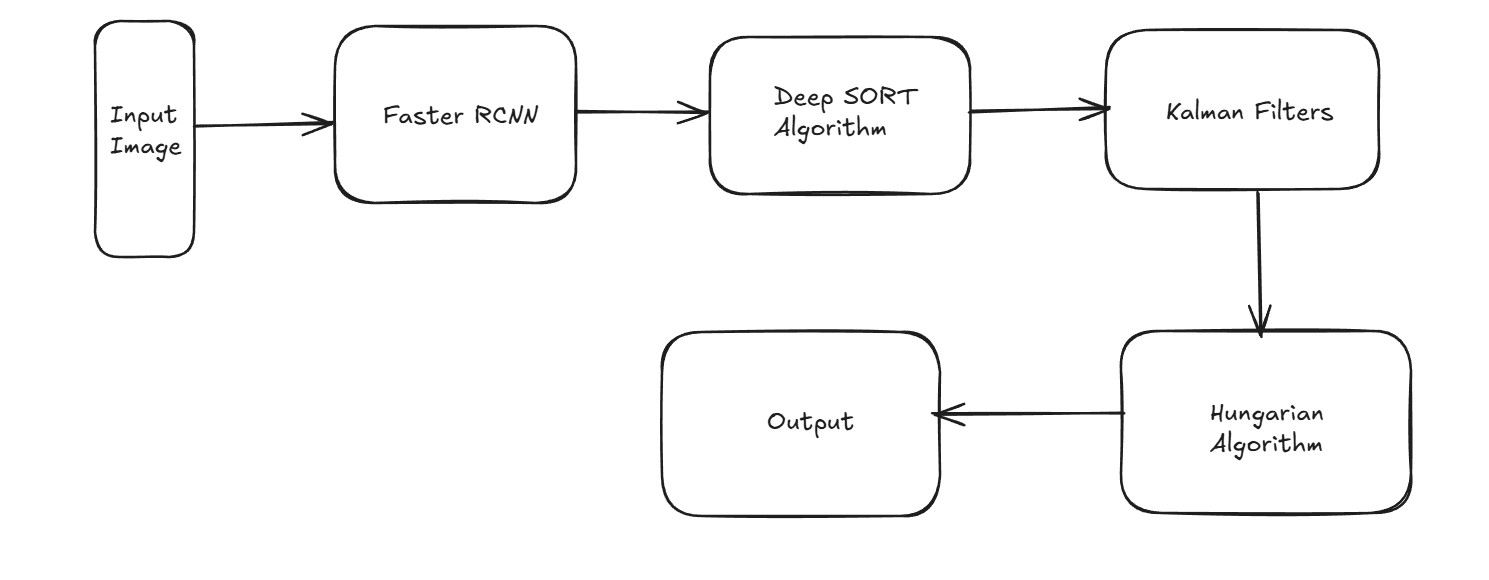

In [1]:
from PIL import Image
image_path = "./Architecture.png"
image = Image.open(image_path)
image.show()

### Solution Architecture

1) Detection bounding boxes are passed from the pretrained faster RCNN model. The feature extractor computes an embedding for each detection.
2) The Kalman Filter predicts the next positions of the objects
3) Hungarian Algorithm is used to match the detections to the predicted positions. A cost matrix is computed based on IoU.
4) Tracks are updated based on the detections, unmatched detections are removed and new detections start new tracks.

### Kalman Filter

The Kalman Filter is a recursive algorithm used to estimate the state of a dynamic system from a series of noisy measurements. 




#### 1. State
The state represents the variables describing the system.  
Example: In a tracking system, the state could be:

$$
\mathbf{x} = 
\begin{bmatrix} 
x \\ 
\dot{x} 
\end{bmatrix}
$$

where \(x\) is position and \(\dot{x}\) is velocity.


#### 2. System Model
The system evolves over time according to the equation:

$$
\mathbf{x}_k = \mathbf{A} \mathbf{x}_{k-1} + \mathbf{B} \mathbf{u}_k + \mathbf{w}_k
$$

- $\mathbf{x}_k$: State at time $k$.  
- $\mathbf{A}$: State transition matrix.  
- $\mathbf{B}$: Control matrix.  
- $\mathbf{u}_k$: Control input.  
- $\mathbf{w}_k$: Process noise.


#### 3. Measurement Model
The observed measurements are related to the state by:

$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$

- $\mathbf{z}_k$: Measurement at time $k$.  
- $\mathbf{H}$: Observation matrix.  
- $\mathbf{v}_k$: Measurement noise.


#### 4. Assumptions
- Process noise ($\mathbf{w}_k $) and measurement noise ($ \mathbf{v}_k $) are independent and Gaussian:

$$
\mathbf{w}_k \sim \mathcal{N}(0, \mathbf{Q}), \quad \mathbf{v}_k \sim \mathcal{N}(0, \mathbf{R})
$$

- $\mathbf{Q}$: Covariance of process noise.  
- $\mathbf{R}$: Covariance of measurement noise.
The state is predicted based on the system model:

$$
\hat{\mathbf{x}}_{k|k-1} = \mathbf{A} \hat{\mathbf{x}}_{k-1|k-1} + \mathbf{B} \mathbf{u}_k
$$

The error covariance is updated as:

$$
\mathbf{P}_{k|k-1} = \mathbf{A} \mathbf{P}_{k-1|k-1} \mathbf{A}^\top + \mathbf{Q}
$$
- $\hat{\mathbf{x}}_{k|k-1}$: Predicted state estimate at time $k$.  
- $\mathbf{P}_{k|k-1}$: Predicted error covariance matrix.


#### 2. Update
The predicted state is corrected based on new measurements.

Kalman Gain:-

$$
\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^\top \left( \mathbf{H} \mathbf{P}_{k|k-1} \mathbf{H}^\top + \mathbf{R} \right)^{-1}
$$

State Update:-

$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \left( \mathbf{z}_k - \mathbf{H} \hat{\mathbf{x}}_{k|k-1} \right)
$$

Covariance Update:-

$$
\mathbf{P}_{k|k} = \left( \mathbf{I} - \mathbf{K}_k \mathbf{H} \right) \mathbf{P}_{k|k-1}
$$



#### Hungarian Algorithm

The Hungarian Algorithm is a combinatorial optimization algorithm used to solve the assignment problem. We have a set of predicted tracks from the Kalman Filters and a set of detections (bounding boxes) in the current frame from the object detector. The goal is to assign detections to tracks such that the total cost of assignment is minimized. The Hungarian algorithm requires a cost matrix where each row represents a track, each column represents a detection and each element of the matrix represents the "cost" of assigning a detection to a track. The cost is based on the IoU. This is implemented using the linear_sum_assignment function from scipy.optimize.

In [ ]:


class KalmanFilterDeepSort:
    def __init__(self):
        self.dt = 1  # time step
        self.A = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        self.Q = np.eye(4) * 0.01
        self.R = np.eye(2) * 0.1
        self.P = np.eye(4) * 1
        self.state = np.zeros(4)

    def predict(self):
        self.state = self.A @ self.state
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.state[:2]

    def update(self, measurement):
        y = measurement - (self.H @ self.state)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.state = self.state + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.state[:2]


In [ ]:
class Track:
    def __init__(self, track_id, bbox, feature):
        self.track_id = track_id
        self.kalman_filter = KalmanFilterDeepSort()
        self.kalman_filter.state[:2] = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]  # initialize position
        self.features = [feature]
        self.age = 1
        self.hits = 1
        self.time_since_update = 0
        self.bbox = bbox

    def predict(self):
        self.kalman_filter.predict()
        self.age += 1
        self.time_since_update += 1

    def update(self, bbox, feature):
        self.kalman_filter.update([(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2])
        self.features.append(feature)
        self.bbox = bbox
        self.hits += 1
        self.time_since_update = 0

    def to_tlbr(self):
        return self.bbox

In [ ]:
class DeepSORT:
    def __init__(self):
        self.tracks = []
        self.next_track_id = 1

    def predict(self):
        for track in self.tracks:
            track.predict()

    def update(self, detections, features):
        # Matching existing tracks with detections using IoU and feature similarity
        if len(self.tracks) == 0:
            for i in range(len(detections)):
                self.create_track(detections[i], features[i])
            return

        # Compute IoU distance matrix
        cost_matrix = np.zeros((len(self.tracks), len(detections)), dtype=np.float32)
        for i, track in enumerate(self.tracks):
            for j, det in enumerate(detections):
                iou = self.iou(track.to_tlbr(), det)
                cost_matrix[i, j] = 1 - iou

        # Hungarian algorithm for track assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        assigned_tracks = []
        for i, j in zip(row_ind, col_ind):
            if cost_matrix[i, j] < 0.7:
                self.tracks[i].update(detections[j], features[j])
                assigned_tracks.append(i)

        unassigned_detections = set(range(len(detections))) - set(col_ind)
        for i in unassigned_detections:
            self.create_track(detections[i], features[i])

        self.tracks = [t for t in self.tracks if t.time_since_update <= 10]

    def create_track(self, bbox, feature):
        track = Track(self.next_track_id, bbox, feature)
        self.tracks.append(track)
        self.next_track_id += 1

    @staticmethod
    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou

In [ ]:
video_path = 'Football_match.mp4'
cap = cv2.VideoCapture(video_path)
tracker = DeepSORT()
output_frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    boxes, scores, labels = detect_objects(frame)
    detections = np.array(boxes)
    features = [np.zeros((128,)) for _ in boxes]

    tracker.predict()
    tracker.update(detections, features)

    for track in tracker.tracks:
        x_min, y_min, x_max, y_max = track.to_tlbr()
        cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track.track_id}', (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    output_frames.append(frame)

cap.release()

In [13]:
first_frame = output_frames[0]
frame_height, frame_width = first_frame.shape[:2]
print(frame_height, frame_width)

output_video_path = 'Task2_Output.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30.0, (frame_width,frame_height))
for frame in output_frames:
    out.write(frame)
out.release()
print(f"Video saved at {output_video_path}")

720 1280
Video saved at Task2_Output.mp4
